In [1]:
import warnings
warnings.filterwarnings("ignore")

In [18]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
# from tensorflow.keras.optimizers.legacy import Adam

In [3]:
train_dir = "../dataset/train" #passing the path with training images
test_dir = "../dataset/test"   #passing the path with testing images

In [4]:
# Total train/test sample
def count_exp(path, set_):
    dict_ = {}
    for expression in os.listdir(path):
        dir_ = path + '/'+expression
        dict_[expression] = len(os.listdir(dir_))
    df = pd.DataFrame(dict_, index=[set_])
    return df
train_count = count_exp(train_dir, 'train')
test_count = count_exp(test_dir, 'test')
print(train_count)
print(test_count)

       angry  disgust  fear  happy  neutral   sad  surprise
train   3995      436  4097   7215     4965  4830      3171
      angry  disgust  fear  happy  neutral   sad  surprise
test    958      111  1024   1774     1233  1247       831


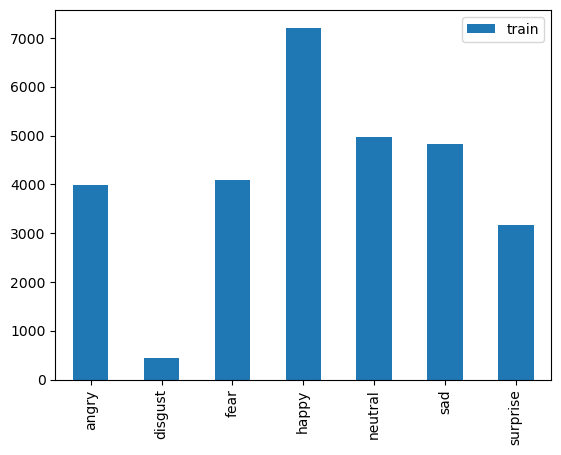

In [5]:
train_count.transpose().plot(kind='bar');

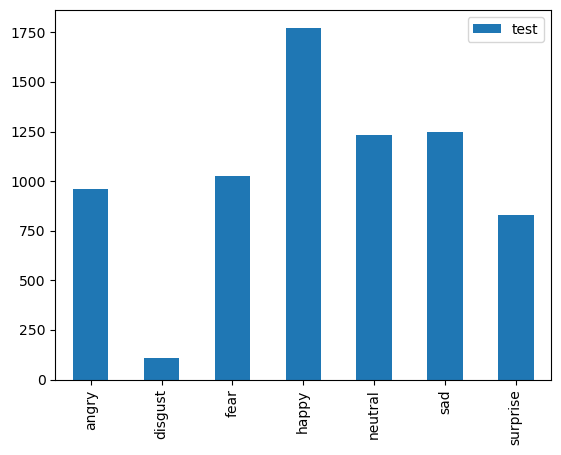

In [6]:
test_count.transpose().plot(kind='bar');

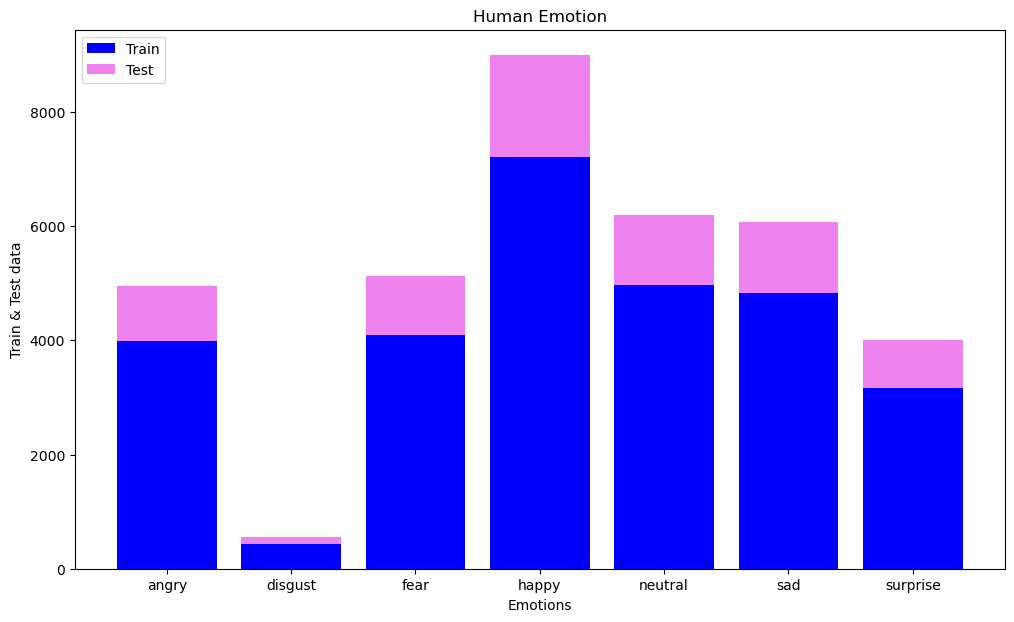

In [7]:
# # lot distribution of train/test dataste per class

x = list(test_count.columns)
y1 =train_count.iloc[0].to_list()
y2 = test_count.iloc[0].to_list()
plt.figure(figsize=(12,7))

plt.bar(x, y1, color='blue')
plt.bar(x, y2, bottom=y1, color='violet')
plt.xlabel("Emotions")
plt.ylabel("Train & Test data")
plt.legend(["Train", "Test"], loc='upper left')
plt.title("Human Emotion")
plt.savefig('distribution.png')
plt.show()

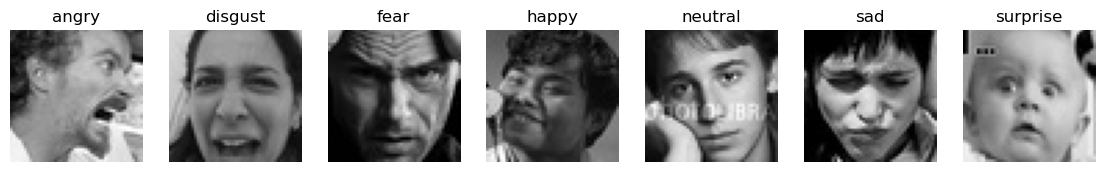

In [8]:
# Plot image of each class
plt.figure(figsize=(14,22))
i = 1
for expression in os.listdir(test_dir):
    img = load_img((test_dir  +'/'+ expression +'/'+ os.listdir(test_dir +'/'+ expression)[1]))
    plt.subplot(1,7,i)
    plt.imshow(img)
    plt.title(expression)
    plt.axis('off')
    i += 1
plt.show()

In [9]:
IMG_SIZE = 48 #original size of the image
IMAGE_SIZE = (IMG_SIZE,IMG_SIZE)
IMAGE_SHAPE = IMAGE_SIZE + (3,)
COLOR_MODE = "grayscale"
CLASS_MODE = "categorical"
BS = 64
EPOCHS = 60

In [10]:
train_datagen = ImageDataGenerator(width_shift_range = 0.1, height_shift_range = 0.1, horizontal_flip = True, rescale = 1./255,validation_split = 0.2 )
validation_datagen = ImageDataGenerator(rescale = 1./255, validation_split = 0.2)

In [11]:
train_dataset = train_datagen.flow_from_directory(directory = train_dir, target_size = IMAGE_SIZE,  batch_size = BS, color_mode = COLOR_MODE,  class_mode =CLASS_MODE, subset = "training" )
test_dataset = validation_datagen.flow_from_directory( directory = test_dir, target_size = IMAGE_SIZE, batch_size = BS, color_mode = COLOR_MODE,  class_mode = CLASS_MODE, subset = "validation" )

Found 22968 images belonging to 7 classes.
Found 1432 images belonging to 7 classes.


In [12]:
# Data labels
classes=['Angry','Disgust','Fear','Happy','Neutral','Sad','Surprise']
emotion_dict = train_dataset.class_indices
emotion_dict

{'angry': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprise': 6}

In [13]:
#emojis unicodes #
emojis = {
    0: "\U0001f620",
    1: "\U0001F922",
    2: "\U0001f628",
    3: "\U0001f60A",
    4: "\U0001f610",
    5: "\U0001f625",
    6: "\U0001f632"
}
print(emojis.values(), sep=" ")

dict_values(['😠', '🤢', '😨', '😊', '😐', '😥', '😲'])


In [15]:
import tensorflow as tf

In [16]:
# VGG16

base_model = tf.keras.applications.VGG16(input_shape= IMAGE_SHAPE,include_top=False,weights="imagenet")
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0     

In [17]:
def get_model(input_size, classes=7):
     #Initialising the CNN
    model = tf.keras.models.Sequential()   

    model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape =input_size))
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(2, 2))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01)))
    model.add(Conv2D(256, kernel_size=(3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(classes, activation='softmax'))

    #Compliling the model
    model.compile(optimizer=Adam(lr=0.0001, decay=1e-6), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])
    return model

In [40]:
fernet = get_model((IMG_SIZE,IMG_SIZE,1))
fernet.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_32 (Conv2D)          (None, 48, 48, 32)        320       
                                                                 
 conv2d_33 (Conv2D)          (None, 48, 48, 64)        18496     
                                                                 
 batch_normalization_15 (Ba  (None, 48, 48, 64)        256       
 tchNormalization)                                               
                                                                 
 max_pooling2d_14 (MaxPooli  (None, 24, 24, 64)        0         
 ng2D)                                                           
                                                                 
 dropout_17 (Dropout)        (None, 24, 24, 64)        0         
                                                                 
 conv2d_34 (Conv2D)          (None, 24, 24, 128)     

In [39]:
from keras.layers import Conv2D,BatchNormalization,MaxPooling2D,Dropout,Flatten,Dense
from keras import regularizers
from tensorflow.keras.optimizers.legacy import Adam

In [51]:
chk_path = 'ferNet.h5'
log_dir = "checkpoint/logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

checkpoint = ModelCheckpoint(filepath=chk_path, save_best_only=True,  verbose=1,  mode='min', moniter='val_loss')

earlystop = EarlyStopping(monitor='val_loss',   min_delta=0,   patience=3,  verbose=1,  restore_best_weights=True)
                        
reduce_lr = ReduceLROnPlateau(monitor='val_loss',  factor=0.2,   patience=6,   verbose=1,   min_delta=0.0001)


tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
csv_logger = CSVLogger('training.log')

callbacks = [checkpoint, reduce_lr, csv_logger]

In [50]:
import datetime
from keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau,CSVLogger

In [53]:
steps_per_epoch = train_dataset.n // train_dataset.batch_size
validation_steps = test_dataset.n // test_dataset.batch_size

In [ ]:
hist = fernet.fit(x=train_dataset,  validation_data=test_dataset,  epochs=EPOCHS, callbacks=callbacks,  steps_per_epoch=steps_per_epoch, validation_steps=validation_steps)

Epoch 1/60
358/358 [==============================] - ETA: 0s - loss: 4.3956 - accuracy: 0.2561
Epoch 1: val_loss improved from inf to 6.07041, saving model to ferNet.h5
358/358 [==============================] - 219s 610ms/step - loss: 4.3956 - accuracy: 0.2561 - val_loss: 6.0704 - val_accuracy: 0.1768 - lr: 1.0000e-04
Epoch 2/60
358/358 [==============================] - ETA: 0s - loss: 3.7144 - accuracy: 0.3047
Epoch 2: val_loss improved from 6.07041 to 3.42065, saving model to ferNet.h5
358/358 [==============================] - 233s 649ms/step - loss: 3.7144 - accuracy: 0.3047 - val_loss: 3.4207 - val_accuracy: 0.3786 - lr: 1.0000e-04
Epoch 3/60
358/358 [==============================] - ETA: 0s - loss: 3.2439 - accuracy: 0.3431
Epoch 3: val_loss improved from 3.42065 to 2.99388, saving model to ferNet.h5
358/358 [==============================] - 248s 693ms/step - loss: 3.2439 - accuracy: 0.3431 - val_loss: 2.9939 - val_accuracy: 0.3970 - lr: 1.0000e-04
Epoch 4/60
358/358 [======

In [ ]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,2)
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'], loc='upper left')

plt.subplot(1,2,1)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
fernet.save_weights('fernet_bestweight.h5')

In [ ]:
# https://www.kaggle.com/code/aayushmishra1512/emotion-detector
# https://www.kaggle.com/code/drcapa/facial-expression-eda-cnn/notebook
# https://github.com/PrudhviGNV/Facial-Emotion-Recognition-using-CNN/blob/master/Facial_Emotion_Recognition_using_CNN.ipynb
# https://www.kaggle.com/code/anantgupt/facial-emotion-recogination-91-accuracy-train-set
# https://www.kaggle.com/code/hoangdigan/face-emotion-detecting-vgg16-transfer-learning